# Distance Estimation and Angle Recovery

TODO: put equateions

## Content

1. [Data Preparation](Read-Data)
2. 

## Read Data

Data used:
- Protein: 5j0n (symmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5j0n.pdb1-500.jpg)

In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import os
import h5py
import numpy as np
import time

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count, plot_images
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion
from cryoem.distance_estimation import train_siamese
import ipyvolume as ipv
from collections import Counter

In [3]:
tf.__version__

'2.1.0'

In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10120405731158231505
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14383616731117977530
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14402171508257276720
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 2829649322901050614
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:86:00.0, compute capability: 3.5"
]


In [5]:
PROTEIN="5j0n"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [6]:
# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [7]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [8]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [9]:
# plot_angles_count(angles_true)

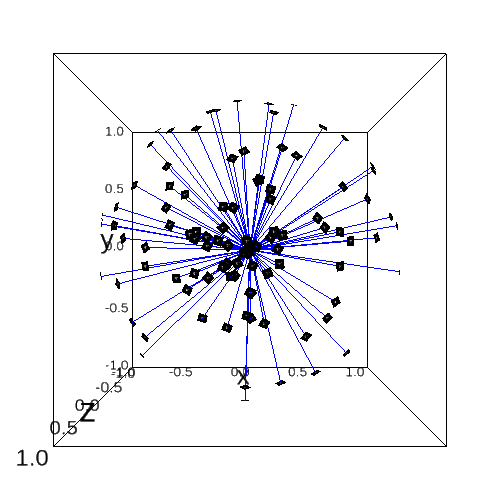

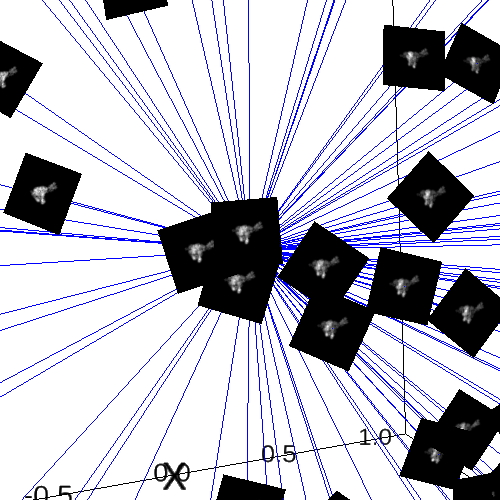

In [10]:
plot_images(angles_true, projections, range(100), img_size_scale=0.05)

In [24]:
ipv.screenshot()

Output()

---

## Prepare for training

In [10]:
from sklearn.model_selection import train_test_split
#from cryoem.distance_estimation import create_pairs

In [11]:
X, y = np.array(data['Projections'], dtype=np.float32), np.array(data['Angles'], dtype=np.float32)

#### Global standardization of projections

In [12]:
def global_standardization(X):
    """Does not have all the positive piels
    Ref: https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/""" 
    print(f'Image shape: {X[0].shape}')
    print(f'Data Type: {X[0].dtype}')
    X = X.astype('float32')

    print("***")
    ## GLOBAL STANDARDIZATION
    # calculate global mean and standard deviation
    mean, std = X.mean(), X.std()
    print(f'Mean: {mean:.3f} | Std: {std:.3f}')
    print(f'Min:  {X.min():.3f} | Max: {X.max():.3f}')
    # global standardization of pixels
    X = (X - mean) / std
    # confirm it had the desired effect
    mean, std = X.mean(), X.std()
    print(f'Mean: {mean:.3f} | Std: {std:.3f}')
    print(f'Min:  {X.min():.3f} | Max: {X.max():.3f}')
    
    return X

In [13]:
def positive_global_standardization(X):
    """Has all positive pixels
    Ref: https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/"""
    mean, std = X.mean(), X.std()
    print(f"Mean: {mean:.3f} | Std: {std:.3f}")

    # global standardization of pixels
    X = (X - mean) / std

    # clip pixel values to [-1,1]
    X = np.clip(X, -1.0, 1.0)

    # shift from [-1,1] to [0,1] with 0.5 mean
    X = (X + 1.0) / 2.0

    # confirm it had the desired effect
    mean, std = X.mean(), X.std()
    print(f'Mean: {mean:.3f} | Std: {std:.3f}')
    print(f'Min:  {X.min():.3f} | Max: {X.max():.3f}')
    
    return X

In [14]:
X = global_standardization(X)

Image shape: (116, 116)
Data Type: float32
***
Mean: 0.262 | Std: 1.046
Min:  0.000 | Max: 15.458
Mean: 0.000 | Std: 1.000
Min:  -0.250 | Max: 14.526


In [15]:
test_size = 0.33
val_size = 0.25

In [16]:
# the data, split between train and test sets
train_idx, test_idx = train_test_split(range(NUM_PROJECTIONS), 
                                       test_size=test_size, 
                                       random_state=42)
train_idx, val_idx= train_test_split(train_idx, 
                                     test_size=val_size, 
                                     random_state=1)

train_idx = sorted(train_idx)
val_idx = sorted(val_idx)
test_idx = sorted(test_idx)

np.savez("data/5j0n/5j0n_siamese_idx", train_idx, val_idx, test_idx)

In [17]:
print(f"TRAIN: {1-test_size:.2f} x {1-val_size:.2f} = {(1-test_size)*(1-val_size):.2f} => {str(int((1-test_size)*(1-val_size)*5000)).rjust(5)} imgs => max pairs: {str(int(np.power((1-test_size)*(1-val_size)*5000, 2))).rjust(10)}")
print(f"TEST : {str(test_size).rjust(18)} => {str(int(test_size*5000)).rjust(5)} imgs => max pairs: {str(int(np.power(test_size*5000, 2))).rjust(10)}")
print(f"VAL  : {1-test_size:.2f} x {val_size:.2f} = {(1-test_size)*val_size:.2f} => {str(int((1-test_size)*val_size*5000)).rjust(5)} imgs => max pairs: {str(int(np.power((1-test_size)*val_size*5000, 2))).rjust(10)}")

TRAIN: 0.67 x 0.75 = 0.50 =>  2512 imgs => max pairs:    6312656
TEST :               0.33 =>  1650 imgs => max pairs:    2722500
VAL  : 0.67 x 0.25 = 0.17 =>   837 imgs => max pairs:     701406


In [18]:
np.save("data/5j0n/test_idx", test_idx)

In [16]:
data = np.load("data/5j0n/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data["arr_0"], data["arr_1"], data["arr_2"]

In [17]:
X = np.stack((X,)*3, axis=-1)

In [18]:
X.shape

(5000, 116, 116, 3)

# 1. Distance Estimation

### Train the model

In [19]:
from time import time

In [20]:
# dQ_values = np.load("data/5j0n/dQ_values.npy")
# dQ_values = np.around(dQ_values, 1)

# cnt = Counter(dQ_values)
# keys = np.array(list(cnt.keys()))
# #values = sum(cnt.values())/np.array(list(cnt.values()))
# values = np.array(list(cnt.values()))
# #values = np.abs((values - np.mean(values)))/np.std(values)
# #values = 0.037 + values
# print(np.min(values))

# coeffs4rprobability = np.polyfit(keys, values, deg=2)
# convert2rprobability = np.poly1d(coeffs4rprobability)

In [21]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    
    def __init__(self, X, y, list_ids, limit_num_pairs=None, limit_style="random", batch_size=256, shuffle=True):
        self.X = X  
        self.y = y  
        # all the possible combinations of 2 image id pairs
        self.pair_ids = np.array(list(zip(*list(map(lambda x: x.flatten(), np.meshgrid(list_ids, list_ids))))))  # e.g. train_idx
        # Don't use all possible combination of pairs, limit them here
        if limit_num_pairs and limit_style=="random":
            limited_pair_indices = np.random.choice(np.arange(len(self.pair_ids)), size=limit_num_pairs)
            self.pair_ids = self.pair_ids[limited_pair_indices]
        #elif limit_num_pairs and limit_style=="uniform":
        #    self.pair_ids = self.pair_ids[np.arange(limit_num_pairs)]
            
        self.batch_size = batch_size    
        self.shuffle = shuffle 
        self._on_epoch_start()
        
    def __len__(self):
        # Denotes the number of batches per epoch
        if len(self.pair_ids)%self.batch_size == 0:
            return len(self.pair_ids) // self.batch_size
        else:
            return len(self.pair_ids) // self.batch_size + 1
        
    def __getitem__(self, index):
        # Generate one batch of data
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find list of ids
        list_ids_batch = np.array([self.pair_ids[k] for k in indices])
        #print(list_ids_batch)

        # Generate data
        idx1, idx2 = list_ids_batch[:,0], list_ids_batch[:,1]
        pairs = np.stack((X[idx1], X[idx2]), axis=1)  # shape: (len(idx1), 2, x.shape[1], x.shape[2], x.shape[3])
        labels = d_q(euler2quaternion(y[idx1]), euler2quaternion(y[idx2]))  # shape: len(idx1)
        #weights = np.array(self._get_weights(labels))
        #labels_and_weights = np.stack((labels, weights), axis=1)
        
        # [training_pairs[:, 0], training_pairs[:, 1]], labels_and_weights
        return [pairs[:, 0], pairs[:, 1]], labels   #labels_and_weights
        
    # def _get_weights(self, labels):
    #      return convert2rprobability(labels)
        
    def _on_epoch_start(self):
        # Updates indices after each epoch
        self.indices = np.arange(len(self.pair_ids))
        if self.shuffle:
            np.random.shuffle(self.indices)     

In [25]:
# idx1 = list(np.random.choice(test_idx, size=1000))
# idx2 = list(np.random.choice(test_idx, size=1000))

# q1_true = euler2quaternion([angles_true[i] for i in idx1])
# q2_true = euler2quaternion([angles_true[i] for i in idx2])

# dQ_values = d_q(q1_true, q2_true).numpy()

In [26]:
# plt.hist(dQ_values, bins=100);

In [27]:
# plt.plot(np.arange(0,np.pi,0.01), convert2rprobability(np.arange(0,np.pi,0.01)), marker="*", markersize=2, lw=0, c="r");

In [28]:
# np.min(convert2rprobability(np.arange(0,np.pi,0.01)))

In [29]:
# len(train_idx)

In [30]:
g = DataGenerator(X, y, train_idx, limit_num_pairs=1000, limit_style="random")

dQ_values_dg = []
for i in g:
    #print(i[0][0].shape, i[1].shape)
    dQ_values_dg.extend(list(i[1].numpy()))
    #print(np.min(i[0][0]), np.max(i[0][0]))

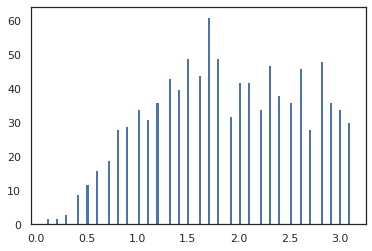

In [31]:
dQ_values_dg= np.around(dQ_values_dg, 1)
plt.hist(dQ_values_dg, bins=100);

In [22]:
import os
import h5py
from time import time, strftime
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pathlib

from cryoem.projections import RotationMatrix
from cryoem.conversions import euler2quaternion, d_q
from cryoem.knn import get_knn_projections

import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.python.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AvgPool2D, Lambda, ZeroPadding2D, Dropout, Concatenate, Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model, multi_gpu_model
#from tensorflow.python.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.losses import KLD, MAE, MSE




def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def mae(y_true, y_pred):
    return K.abs(MAE(y_true, y_pred)) + K.abs(KLD(y_true, y_pred))


def mse(y_true, y_pred):
    return K.abs(MSE(y_true, y_pred)) + K.abs(KLD(y_true, y_pred))

def mlp(vects):
    x, y = vects
    Concatenate(axis=-1)
    
def mlp_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def create_siamese_network(input_shape):
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    input_x = Input(shape=input_shape)
    base_model = MobileNet(weights='imagenet', include_top=False, input_tensor=input_x, input_shape=input_shape)
    x = base_model.layers[-1].output
    
    #for i, layer in enumerate(base_model.layers):
    #    print(i, layer.name, layer.output_shape)

    # add a global spatial average pooling layer
    x = GlobalAveragePooling2D()(x)
    
#     # let's add a fully-connected layer
#     x = Dense(1024, activation='relu')(x)

#     for layer in base_model.layers:
#         layer.trainable = False
    
    return Model(input_x, x)

def create_distance_network(input_shape):
    # ref: https://github.com/guanjianyu/DisNet/blob/master/Train_DisNet.py
    # ref: https://project.inria.fr/ppniv18/files/2018/10/paper22.pdf
    input_x = Input(shape=input_shape)
    
    #x = Flatten()(input_x)

    x = Dense(2000, activation="relu")(input_x)
    x = Dense(2000, activation="relu")(x)
    x = Dense(2000, activation="relu")(x)
    x = Dense(2000, activation="relu")(x)
    x = Dense(1000, activation="relu")(x)
    x = Dense(1000, activation="relu")(x)
    x = Dense(1, activation="relu")(x)
    
    return Model(input_x, x)



def train_siamese(X, y, train_idx, val_idx, epochs_top, epochs_full, batch_size, learning_rate, training_steps=None, validation_steps=None, plot=True, gpus=None):
    #print("TensorFlow version: {}".format(tf.__version__))
    #print("Eager execution: {}".format(tf.executing_eagerly()))
    #tf.config.experimental_run_functions_eagerly(True)
    
    mirrored_strategy = tf.distribute.MirroredStrategy()
    
    with mirrored_strategy.scope():
        # Prepare data generators
        training_generator = DataGenerator(X, y, train_idx, limit_num_pairs=training_steps)
        validation_generator = DataGenerator(X, y, val_idx, limit_num_pairs=validation_steps)
        
        # Setup callbacks
        # Create a callback that saves the model's weights
        #CHECKPOINT_PATH = f"training/{strftime('%Y%m%d_%H%M%S')}"
        #pathlib.Path(CHECKPOINT_PATH).mkdir(parents=True, exist_ok=True)
        #backup_callback = ModelCheckpoint(filepath=CHECKPOINT_PATH,
        #                                  save_weights_only=True,
        #                                  verbose=1)
        # Create a callback that will show tensorboard data
        LOGS_PATH = os.path.join("logs", strftime('%Y%m%d_%H%M%S'))
        pathlib.Path(LOGS_PATH).mkdir(parents=True, exist_ok=True)
        logs_callback = TensorBoard(LOGS_PATH, histogram_freq=1) #, profile_batch=300)#100000000)
        
        # Create a callback that will decrease LR if it gets plateau in val_loss
        #reduce_on_plateau_callback = ReduceLROnPlateau(monitor="loss", mode="min", factor=0.1, patience=20, min_lr=1e-4, verbose=1)
        
        input_shape = tuple(list(X.shape[1:])) #training_pairs[:, 0].shape[1:]
        print(f"Input images shape {input_shape}")

        # network definition
        input_a = Input(shape=input_shape)
        input_b = Input(shape=input_shape)
        cnn_network = create_siamese_network(input_shape)
        
        # because we re-use the same instance `cnn_network`,
        # the weights of the network will be shared across the two branches
        processed_a = cnn_network(input_a)
        processed_b = cnn_network(input_b)

        
        distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
        #siamese_output = Concatenate()([processed_a, processed_b])
        #siamese_output = tf.keras.backend.stack([processed_a, processed_b])
        #print(f"Output shape of the SiameseNN {siamese_output.shape}")
        #distance_network = create_distance_network(siamese_output.shape)
        #distance = distance_network(siamese_output)
        
        m = Model([input_a, input_b], distance)  # was m

        # train
        model = multi_gpu_model(m, gpus=gpus)
        model.summary()
        plot_model(model, to_file="figures/model_plot.png", expand_nested=True, show_shapes=True, show_layer_names=True)

        # training only top layers
        optimizer1 = RMSprop(learning_rate=learning_rate)
        model.compile(loss=mae, optimizer=optimizer1, metrics=[mse], sample_weight_mode=None)
        history1 = model.fit(training_generator, 
                            epochs=epochs_top,
                            validation_data=validation_generator, 
                            callbacks=[logs_callback])
        
        
        if plot:
            # Get training and test loss histories
            training_loss = history1.history['loss']
            val_loss = history1.history['val_loss']
            mses = history1.history['mse']
            val_mses = history1.history['val_mse']

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

            # Create count of the number of epochs
            epoch_count = range(1, len(training_loss) + 1)

            # Visualize loss history
            ax1.plot(epoch_count, training_loss, 'r--', label='MAE Training Loss')
            ax1.plot(epoch_count, val_loss, 'b-', label='MAE Validation Loss')
            ax1.legend()
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')

            ax2.plot(epoch_count, mses, 'r-', label='MSE Training')
            ax2.plot(epoch_count, val_mses, 'b-', label='MSE Validation')
            ax2.legend()
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Loss')
            plt.show();


#         # at this point, the top layers are well trained and we can start fine-tuning
#         # convolutional layers from inception V3. We will freeze the bottom N layers
#         # and train the remaining top layers.

#         # we chose to train the top 2 inception blocks, i.e. we will freeze
#         # the first 249 layers and unfreeze the rest:
#         for layer in model.layers[:249]:
#             layer.trainable = False
#         for layer in model.layers[249:]:
#             layer.trainable = True
            
#         # we train our model again (this time fine-tuning the top 2 inception blocks
#         # alongside the top Dense layers
#         optimizer2 = Adam(lr=1e-3)
#         model.compile(optimizer=optimizer2, loss=mae, metrics=['mse'])
#         history2 = model.fit(training_generator,
#                             epochs=epochs_full,
#                             validation_data=validation_generator, 
#                             callbacks=[logs_callback, reduce_on_plateau_callback])
            
        model_filename = f"training/{strftime('%Y%m%d_%H%M%S')}.h5"
        model.save(model_filename) 
        print(f"Model saved to: {model_filename}")
        
#         if plot:
#             # Get training and test loss histories
#             training_loss = history2.history['loss']
#             val_loss = history2.history['val_loss']
#             mses = history2.history['mse']
#             val_mses = history2.history['val_mse']

#             fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

#             # Create count of the number of epochs
#             epoch_count = range(1, len(training_loss) + 1)

#             # Visualize loss history
#             ax1.plot(epoch_count, training_loss, 'r--', label='MAE Training Loss')
#             ax1.plot(epoch_count, val_loss, 'b-', label='MAE Validation Loss')
#             ax1.legend()
#             ax1.set_xlabel('Epoch')
#             ax1.set_ylabel('Loss')

#             ax2.plot(epoch_count, mses, 'r-', label='MSE Training')
#             ax2.plot(epoch_count, val_mses, 'b-', label='MSE Validation')
#             ax2.legend()
#             ax2.set_xlabel('Epoch')
#             ax2.set_ylabel('Loss')
#             plt.show();

        return model, history1 #, history2

def plot_results(projections, y_pred, y, strtype):
    if projections.shape[-1] == 1:
        projections = projections.reshape(list(projections.shape[:-2]) +[-1])

    def _inner(i):
        
        plt.imfig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(projections[i, 0])
        ax2.imshow(projections[i, 1])

        print(f"--- {strtype} Set ---")
        print(f"predicted: {y_pred[i][0]}")
        print(f"true:      {y[i].numpy()}")
        print(f"mse:       {mse(y_pred[i], y[i].numpy())}")
        print(f"mae:       {mae(y_pred[i], y[i].numpy())}")
        
    return _inner

In [35]:
train_percent = 0.1
val_percent = 0.1
int(train_percent*np.power(len(train_idx), 2)), int(val_percent*np.power(len(val_idx), 2))

(631014, 70224)

In [ ]:
model, history1 = train_siamese(X=X, y=y, 
                               train_idx=train_idx, 
                               val_idx=val_idx,
                               epochs_top=20,  #500
                               epochs_full=None,
                               batch_size=256,  #512 latest 
                               learning_rate=1e-3,  #0.01 
                               training_steps=int(train_percent*np.power(len(train_idx), 2)),  # None
                               validation_steps=int(val_percent*np.power(len(val_idx), 2)),  # None
                               plot=True,
                               gpus=2)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Input images shape (116, 116, 3)


/home/jbanjac/anaconda3/envs/protein_reconstruction/lib/python3.6/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [74]:
#from tensorflow.keras.models import load_model
# import tensorflow_hub as hub

# def build_model(loaded, input_shape):
#     input_x = Input(shape=input_shape)
#     # Wrap what's loaded to a KerasLayer
#     keras_layer = hub.KerasLayer(loaded, trainable=True)(input_x)
#     model = tf.keras.Model(x, keras_layer)
#     return model
    
def continue_training(model_filename, X, y, train_idx, val_idx, epochs_top, epochs_full, batch_size, learning_rate, training_steps=None, validation_steps=None, plot=True, gpus=None):
    #tf.enable_eager_execution()
    
    #mirrored_strategy = tf.distribute.MirroredStrategy()
    
    #with mirrored_strategy.scope():
        
    #input_shape = tuple(list(X.shape[1:])) #training_pairs[:, 0].shape[1:]
    #print(f"Input images shape {input_shape}")

    #loaded = tf.saved_model.load('training/20200521_084626.h5')
    #m = build_model(loaded, input_shape)
    #Load partly trained model
    #m = tf.keras.models.load_model('training/20200521_084626.h5')
    m = tf.keras.models.load_model(model_filename)

    # train
    model = multi_gpu_model(m, gpus=gpus)
    model.summary()
    #plot_model(model, to_file="figures/model_plot.png", expand_nested=True, show_shapes=True, show_layer_names=True)

    training_generator = DataGenerator(X, y, train_idx, limit_num_pairs=training_steps)
    validation_generator = DataGenerator(X, y, val_idx, limit_num_pairs=validation_steps)

    # Setup callbacks
    # Create a callback that saves the model's weights
    #CHECKPOINT_PATH = f"training/{strftime('%Y%m%d_%H%M%S')}"
    #pathlib.Path(CHECKPOINT_PATH).mkdir(parents=True, exist_ok=True)
    #backup_callback = ModelCheckpoint(filepath=CHECKPOINT_PATH,
    #                                  save_weights_only=True,
    #                                  verbose=1)
    # Create a callback that will show tensorboard data
    LOGS_PATH = os.path.join("logs", strftime('%Y%m%d_%H%M%S'))
    pathlib.Path(LOGS_PATH).mkdir(parents=True, exist_ok=True)
    logs_callback = TensorBoard(LOGS_PATH, histogram_freq=1) #, profile_batch=300)#100000000)

    # Create a callback that will decrease LR if it gets plateau in val_loss
    reduce_on_plateau_callback = ReduceLROnPlateau(monitor="loss", mode="min", factor=0.1, patience=20, min_lr=1e-4, verbose=1)


    # training only top layers
    optimizer1 = RMSprop(learning_rate=learning_rate)
    model.compile(loss=mae, optimizer=optimizer1, metrics=['mse'])
    #Continue training
    history = model.fit(training_generator, 
                        epochs=epochs_top,
                        validation_data=validation_generator, 
                        callbacks=[logs_callback, reduce_on_plateau_callback])

    return model, history

In [ ]:
model, history2 = continue_training(model_filename='training/20200521_084626.h5',X=X, y=y, 
                               train_idx=train_idx, 
                               val_idx=val_idx,
                               epochs_top=20,  #500
                               epochs_full=None,
                               batch_size=256,  #512 latest 
                               learning_rate=1e-3,  #0.01 
                               training_steps=int(train_percent*np.power(len(train_idx), 2)),  # None
                               validation_steps=int(val_percent*np.power(len(val_idx), 2)),  # None
                               plot=True,
                               gpus=2)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 3) 0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 116, 116, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 116, 116, 3)  0           input_2[0][0]                    
____________________________________________________________________________________________

---

In [37]:
training_loss = history1.history['loss']
val_loss = history1.history['val_loss']
mses = history1.history['mse']
val_mses = history1.history['val_mse']

np.savez("data/5j0n/5j0n_DE_history_add_loss", training_loss, val_loss, mses, val_mses)

In [35]:
# training_loss2 = history2.history['loss']
# val_loss2 = history2.history['val_loss']
# mses2 = history2.history['mse']
# val_mses2 = history2.history['val_mse']

# np.savez("data/5j0n/5j0n_DE_history_stage2", training_loss2, val_loss2, mses2, val_mses2)

In [36]:
# training_loss += training_loss2
# val_loss += val_loss2
# mses += mses2
# val_mses += val_mses

In [38]:
data = np.load("data/5j0n/5j0n_DE_history_add_loss.npz")
training_loss, val_loss, mses, val_mses = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]

In [40]:
limit = 19

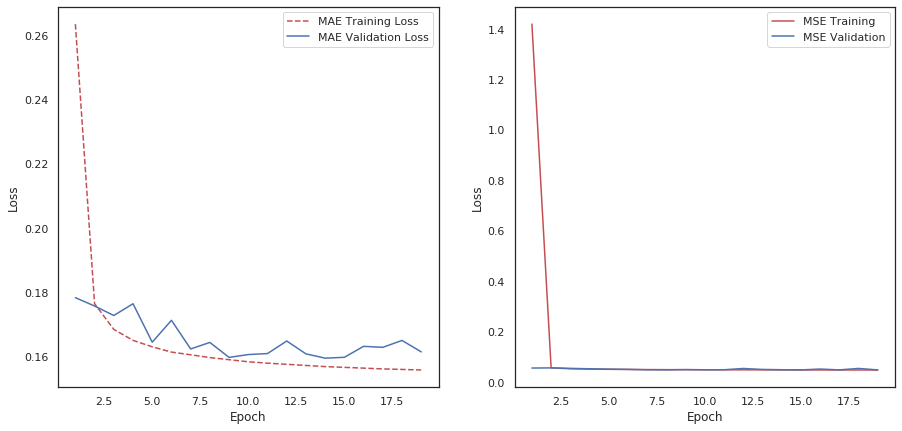

In [41]:
# Get training and test loss histories
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
ax1.plot(epoch_count[:limit], training_loss[:limit], 'r--', label='MAE Training Loss')
ax1.plot(epoch_count[:limit], val_loss[:limit], 'b-', label='MAE Validation Loss')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(epoch_count[:limit], mses[:limit], 'r-', label='MSE Training')
ax2.plot(epoch_count[:limit], val_mses[:limit], 'b-', label='MSE Validation')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
plt.show();

In [42]:
training_loss[limit], val_loss[limit], mses[limit], val_mses[limit]

(0.15569540567544324, 0.15953983762047508, 0.049236886, 0.04864242)

In [40]:
training_loss[limit], val_loss[limit], mses[limit], val_mses[limit]

(0.00010196198448029379, 0.00013733559804016046, 4.607726e-06, 9.539637e-06)

In [41]:
training_loss[limit], val_loss[limit], mses[limit], val_mses[limit]

(20.34968684555079, 20.15308006286621, 17.759182, 17.617468)

In [37]:
# training_loss[50], val_loss[50], mses[50], val_mses[50]

### (Or) Read model checkpoint

In [40]:
# stop here, change file

In [23]:
# #model_filename = "training/20191218_023743.h5"

# On LTS: "training/20200221_061000.h5"
# model_filename = "training/20200220_055622.h5" local, MSE as loss, 60K training
#model_filename = "training/20200305_055207.h5" # local, MAE as loss, 60K training
#model_filename = "training/20200416_094914.h5"
#model_filename = "training/20200417_192953.h5"
#model_filename = "training/20200418_190002.h5"
#model_filename = "training/20200418_190118.h5" for symmetric
#model_filename = "training/20200422_114231.h5"
#model_filename = "training/20200430_022437.h5" full 2
#model_filename = "training/20200430_212106.h5" full 3
#model_filename = "training/20200504_232357.h5"
#model_filename = "training/20200505_191430.h5"  PGN
#model_filename = "training/20200507_070831.h5" 
#model_filename = "training/20200508_020958.h5" # fixed MLP + MobileNet | NOT REALLY was ran with Eucl
# small ds

#model_filename = "training/20200508_020958.h5"
#model_filename = "training/20200526_054602.h5"
model_filename = "training/20200527_091717.h5"

In [24]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 116, 116, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 116, 116, 3)  0           input_2[0][0]                    
____________________________________________________________________________________________

### Some model results

In [40]:
# from cryoem.distance_estimation import plot_results

In [41]:
# y_tr_pred = model.predict_on_batch([tr_pairs[:256, 0], tr_pairs[:256, 1]])
# y_val_pred = model.predict_on_batch([val_pairs[:256, 0], val_pairs[:256, 1]])

In [42]:
# plot_train_results = plot_results(tr_pairs, y_tr_pred, tr_y, "Train")
# plot_validation_results = plot_results(val_pairs, y_val_pred, val_y, "Validation")

In [43]:
# plot_train_results(1)

In [44]:
# plot_validation_results(0)

---

## dP/dQ plot

In [25]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [58]:
#get_output = K.function([model.layers[0].input],[model.layers[7].output])
#model_output = get_output([X_test])[0]

In [59]:
def d_p(p1, p2):
    dist = []
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)

    #model.run_eagerly = False
    #dist = model([p1, p2], training=False)
    dist = get_output([p1, p2])
    
    return dist

In [60]:
start_time = time()
idx1 = list(np.random.choice(test_idx, size=1000))
idx2 = list(np.random.choice(test_idx, size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).numpy().T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

time()-start_time

InvalidArgumentError:  You must feed a value for placeholder tensor 'input_2' with dtype float and shape [?,116,116,3]
	 [[node input_2 (defined at <ipython-input-57-27b4442dd956>:1) ]] [Op:__inference_keras_scratch_graph_60098]

Function call stack:
keras_scratch_graph


In [32]:
start_time = time()
idx1 = list(np.random.choice(test_idx, size=1000))
idx2 = list(np.random.choice(test_idx, size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).numpy().T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

time()-start_time

32.74556922912598

In [29]:
# np.savez("data/5j0n/5j0n_DE_dPdQ_plot_full_add_loss", dP_values, dQ_values)

In [30]:
# data = np.load("data/5j0n/5j0n_DE_dPdQ_plot_full_add_loss.npz")
# dP_values, dQ_values = data['arr_0'], data['arr_1']

<Figure size 432x288 with 0 Axes>

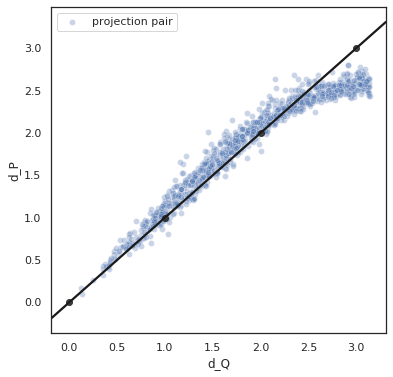

<Figure size 432x288 with 0 Axes>

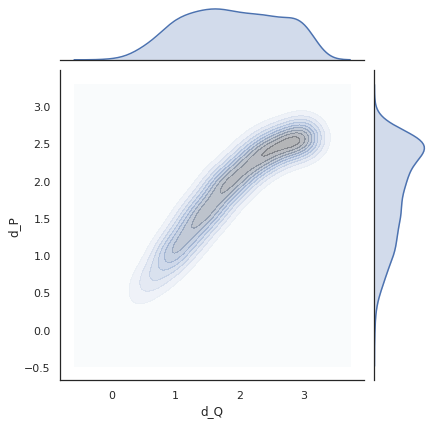

Variance = 0.21152556471664916
Min. angle recovery loss possible = 0.04469832146416863


In [45]:
plot_dP_dQ(dP_values, dQ_values)

In [28]:
MAE(dQ_values, dP_values)

<tf.Tensor: shape=(), dtype=float64, numpy=0.1553496223657692>

In [29]:
KLD(dQ_values, dP_values)

<tf.Tensor: shape=(), dtype=float64, numpy=-6.50270772042796>

In [30]:
MAE(dQ_values, dP_values)*KLD(dQ_values, dP_values)

<tf.Tensor: shape=(), dtype=float64, numpy=-1.0101931887234556>

In [31]:
MAE(dQ_values, dP_values)+KLD(dQ_values, dP_values)

<tf.Tensor: shape=(), dtype=float64, numpy=-6.347358098062191>

<Figure size 432x288 with 0 Axes>

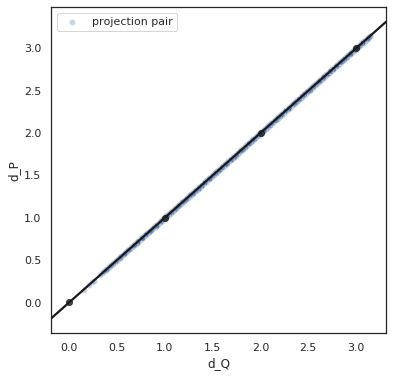

<Figure size 432x288 with 0 Axes>

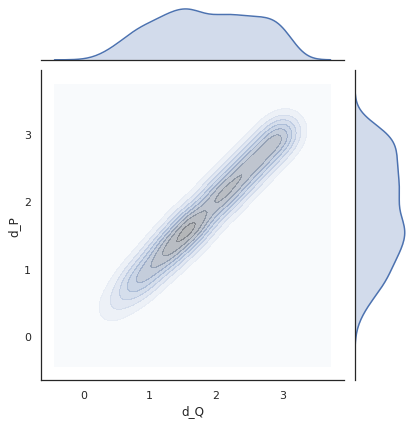

Variance = 0.0
Min. angle recovery loss possible = 0.0


In [52]:
plot_dP_dQ(dQ_values, dQ_values)

In [50]:
KLD(dQ_values, dQ_values)

<tf.Tensor: shape=(), dtype=float64, numpy=0.0>

In [51]:
MAE(dQ_values, dQ_values)

<tf.Tensor: shape=(), dtype=float64, numpy=0.0>

In [32]:

idx1 = list(np.random.choice(train_idx, size=1000))
idx2 = list(np.random.choice(train_idx, size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).numpy().T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

<Figure size 432x288 with 0 Axes>

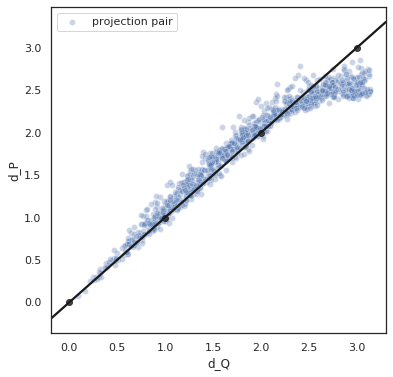

<Figure size 432x288 with 0 Axes>

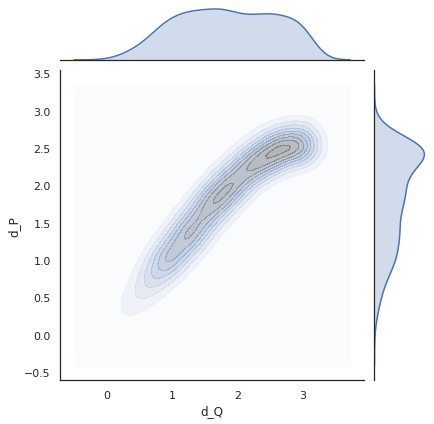

Variance = 0.20384588782777013
Min. angle recovery loss possible = 0.04151159283830755


In [33]:
plot_dP_dQ(dP_values, dQ_values)

In [34]:
MAE(dQ_values, dP_values)

<tf.Tensor: shape=(), dtype=float64, numpy=0.15041967870757103>

In [35]:
KLD(dQ_values, dP_values)

<tf.Tensor: shape=(), dtype=float64, numpy=-7.186807989928095>

In [36]:
MAE(dQ_values, dP_values)*KLD(dQ_values, dP_values)

<tf.Tensor: shape=(), dtype=float64, numpy=-1.0810373487779885>

In [37]:
MAE(dQ_values, dP_values)+KLD(dQ_values, dP_values)

<tf.Tensor: shape=(), dtype=float64, numpy=-7.036388311220524>

# 2. Angle Recovery

## Angle Recovery

Perfect distances. Learning rate 0.01

In [38]:
from cryoem.angle_recovery import train_angle_recovery

In [39]:
# X = tf.cast(X, dtype=tf.float64)
# X = X.numpy()

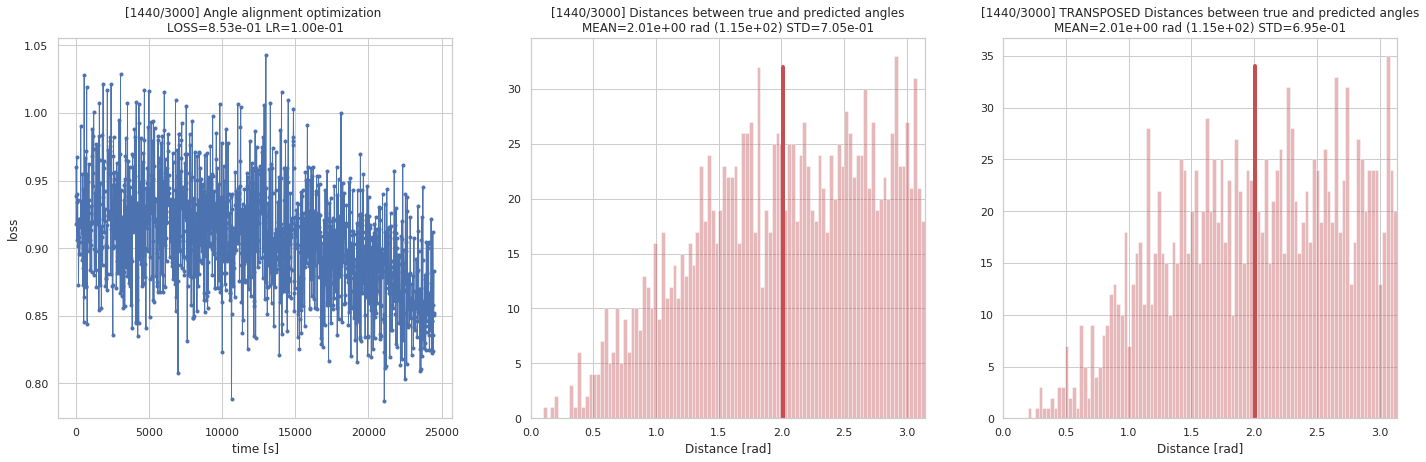

In [ ]:
q_predicted, losses, q_all = train_angle_recovery(steps=3000, 
                                                   batch_size=512, 
                                                   in_data=X[test_idx], 
                                                   distance_fn=d_p, 
                                                   learning_rate=0.1,
                                                   angles_true=y[test_idx],
                                                   optimization=True)

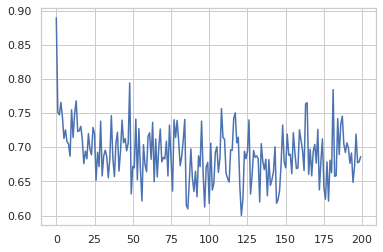

In [49]:
plt.plot(losses)

In [55]:
np.save("data/5j0n/predicted_quaternions_siamese_losses_full_mobilenet_mlp_small_all.npy",     losses)
np.save("data/5j0n/predicted_quaternions_siamese_iterations_full_mobilenet_mlp_small_all.npy", q_all)
np.save("data/5j0n/predicted_quaternions_siamese_full_mobilenet_mlp_small_all.npy",            q_predicted.numpy())

In [57]:
from cryoem.conversions import quaternion2euler
angles_predicted = quaternion2euler(q_predicted).numpy()%(2*np.pi)
np.save("data/5j0n/predicted_angles_siamese_full_mobilenet_mlp_small_all.npy", angles_predicted)

##### Plots

In [59]:
losses      = np.load("data/5j0n/predicted_quaternions_siamese_losses_full_mobilenet_mlp_small_all.npy")
q_all       = np.load("data/5j0n/predicted_quaternions_siamese_iterations_full_mobilenet_mlp_small_all.npy")
q_predicted = np.load("data/5j0n/predicted_quaternions_siamese_full_mobilenet_mlp_small_all.npy")

In [61]:
from cryoem.plots import plot_iterations_polar_plot, plot_iterations_rotvec

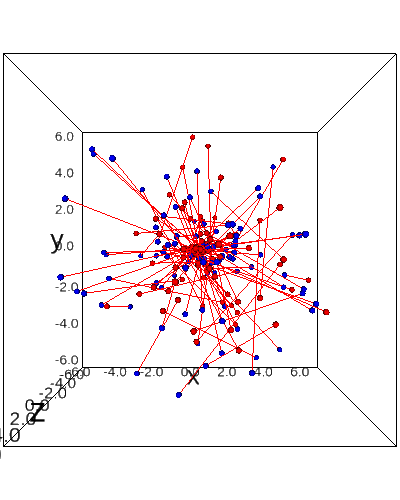

In [65]:
plot_iterations_polar_plot(q_all, angles_true[test_idx], interval=100, selected=range(102));

In [66]:
ipv.screenshot()

Output()

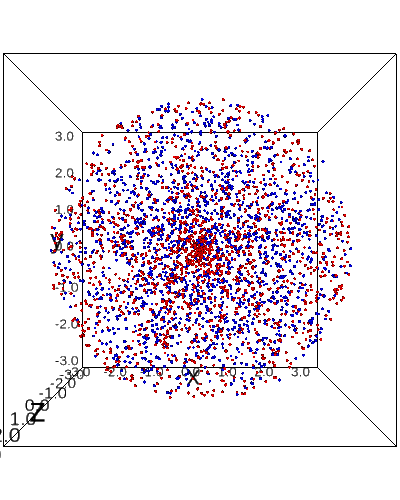

In [67]:
plot_iterations_rotvec(q_all, angles_true[test_idx], interval=100);

In [68]:
ipv.screenshot()

Output()

In [69]:
from cryoem.plots import plot_images

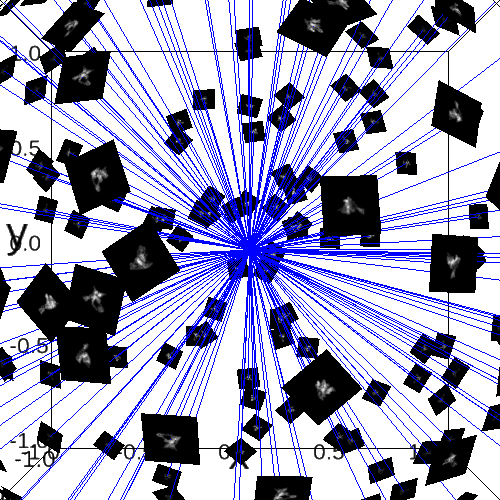

In [70]:
plot_images(angles_predicted, projections, indices=range(200), img_size_scale=0.1)

In [71]:
ipv.screenshot()

Output()

---

# Angle Alignment

#### Prediction angles from previous phase that we want to align with true angles

---

#### Run the Optimization

The `rotation` is our minimizer and we initialize this 6D vector with random values. That is the reason the optimization sometimes converges to 0 loss and sometimes not.

In [77]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion

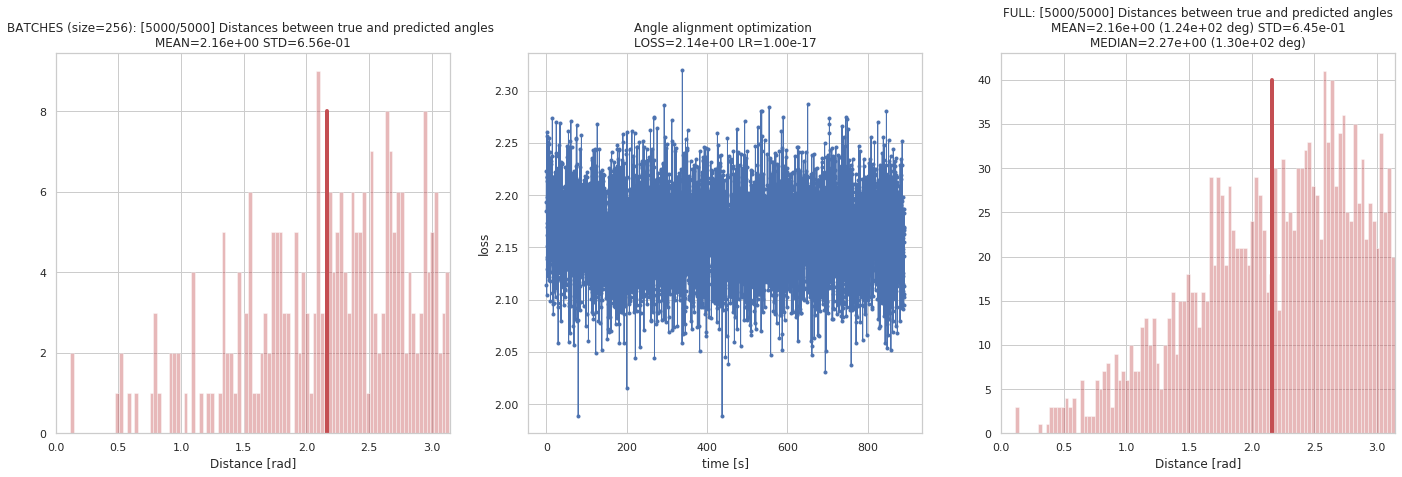

step 500/5000 (96s): loss = 2.17e+00
step 1000/5000 (183s): loss = 2.16e+00
step 1500/5000 (271s): loss = 2.16e+00
step 2000/5000 (358s): loss = 2.16e+00
step 2500/5000 (446s): loss = 2.16e+00
step 3000/5000 (534s): loss = 2.16e+00
step 3500/5000 (622s): loss = 2.16e+00
step 4000/5000 (713s): loss = 2.16e+00
step 4500/5000 (806s): loss = 2.16e+00
step 5000/5000 (892s): loss = 2.16e+00

---


In [80]:
m, rotation, loss, collect_data  = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                                 steps=5000, 
                                                 batch_size=256, 
                                                 learning_rate=0.01, 
                                                 angles_true=angles_true[test_idx], 
                                                 angles_predicted=angles_predicted)

In [81]:
m, rotation[0].numpy(), loss[-1]

([1.0, 1.0, 1.0, 1.0],
 array([2.13355493, 3.20832761, 3.42499508, 1.13235032, 6.07880364,
        3.57704655]),
 2.1625712105857064)

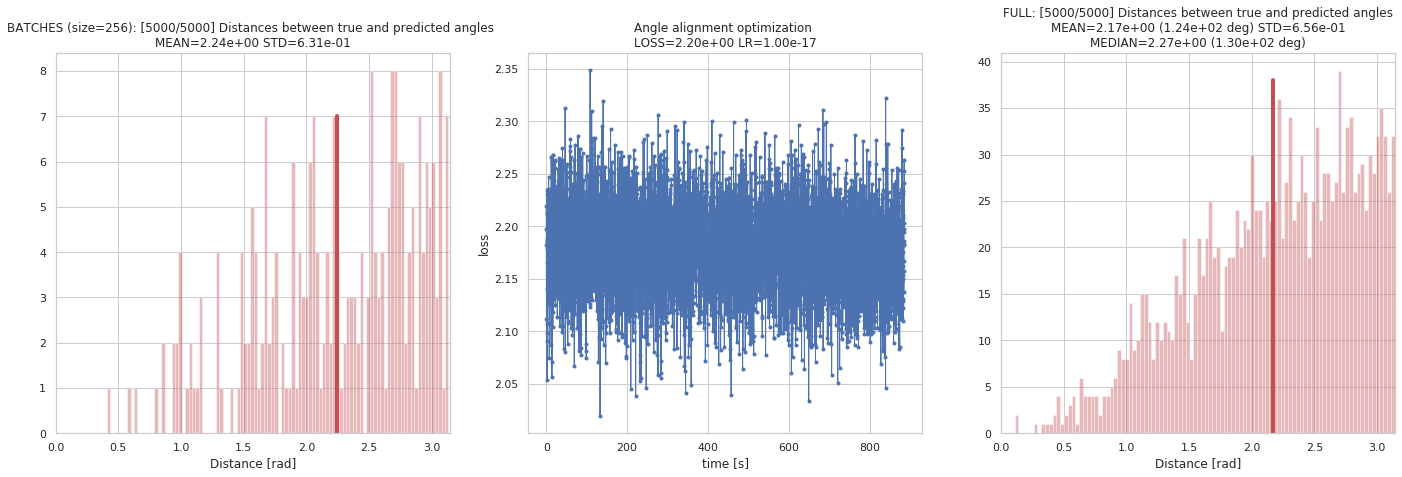

step 500/5000 (89s): loss = 2.18e+00
step 1000/5000 (176s): loss = 2.18e+00
step 1500/5000 (262s): loss = 2.18e+00
step 2000/5000 (349s): loss = 2.18e+00
step 2500/5000 (439s): loss = 2.18e+00
step 3000/5000 (527s): loss = 2.18e+00
step 3500/5000 (617s): loss = 2.18e+00
step 4000/5000 (702s): loss = 2.18e+00
step 4500/5000 (794s): loss = 2.17e+00
step 5000/5000 (886s): loss = 2.17e+00

---


In [75]:
m, rotation, loss, collect_data  = training_angle_alignment(m=[-1.0, 1.0, 1.0, 1.0],
                                                 steps=5000, 
                                                 batch_size=256, 
                                                 learning_rate=0.001, 
                                                 angles_true=angles_true[test_idx], 
                                                 angles_predicted=angles_predicted)

In [76]:
m, rotation[0].numpy(), loss[-1]

([-1.0, 1.0, 1.0, 1.0],
 array([ 1.773942  ,  5.92012581,  2.25840017,  4.82399805,  2.68053836,
        -0.25358452]),
 2.2411800965408157)

##### Plots

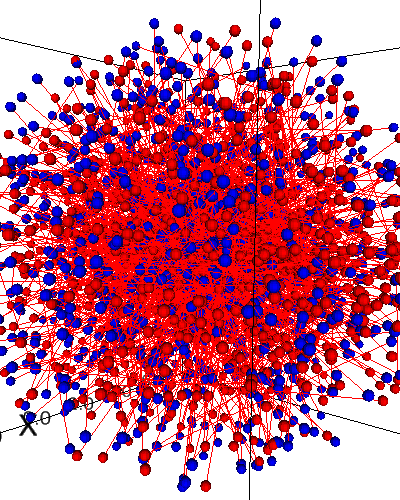

In [83]:
plot_iterations_polar_plot(collect_data, angles_true[test_idx], interval=100);

In [84]:
ipv.screenshot()

Output()

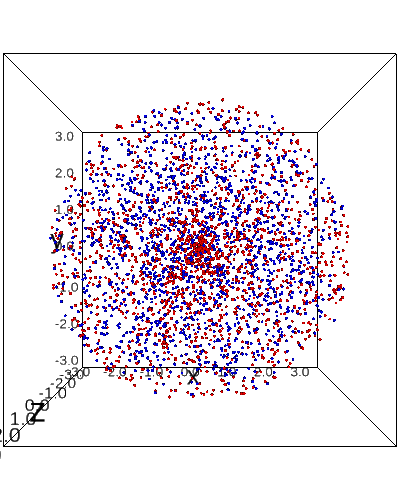

In [85]:
plot_iterations_rotvec(collect_data, angles_true[test_idx]);

In [86]:
ipv.screenshot()

Output()

In [87]:
qpn = euler2quaternion(angles_predicted)

qpa = update_quaternion(m=m, 
                        a_R=rotation, 
                        q_predicted=qpn)

angles_predicted_rotated = quaternion2euler(qpa).numpy()

np.save("data/5j0n/predicted_angles_siamese_updated_full_mlp_mobilenet.npy", angles_predicted_rotated)

In [51]:
# Image(filename='../3-reconstruction/data/5j0n_projections_and_angles_predicted_updated.png')